In [1]:
! git clone https://github.com/mshakerinava/IFT6269-A20-proj6.git

Cloning into 'IFT6269-A20-proj6'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 10), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class ResBlock(nn.Module):
    #stride?
    def __init__(self, in_size, out_size, stride=1):
        super(ResBlock, self).__init__()

        self.stride = stride
        self.conv_block1 = nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1)
        self.conv_block2 = nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1)
        self.avgPool = nn.AvgPool2d(kernel_size=stride, stride=stride)

        self.identity_pad = nn.Identity()
        if in_size != out_size: # we don't want to change dim for the 1st residual block layers, why?
            self.identity_pad = nn.Conv2d(in_size, out_size, kernel_size=1, stride=1)

    def forward(self, x):
        if self.stride > 1:
            x = self.avgPool(x)
        out_block = self.conv_block1(x)
        out_block = F.leaky_relu(out_block)
        out_block = self.conv_block2(out_block)
        out_block = F.leaky_relu(out_block)
        return out_block + self.identity_pad(x)

In [4]:
def res_block_layers(in_size, out_size, num_res_block, stride=1):
    layers = []

    #append the first layer
    layers.append(ResBlock(in_size, out_size, stride))

    #append the remaining layers
    for i in range(1, num_res_block):
        layers.append(ResBlock(out_size, out_size))

    return nn.Sequential(*layers)

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3)
        self.res_block1 = res_block_layers(32, 64, 3, stride=2)
        self.res_block2 = res_block_layers(64, 128, 3, stride=2)
        self.res_block3 = res_block_layers(128, 256, 3, stride=2)
        self.linear = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv(x)
        x = F.leaky_relu(x)

        #residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # x.shape == [BATCH_SIZE, 256, 4, 4]
        x = torch.sum(x, dim=[2, 3])
        x = self.linear(x)
        return x

In [6]:
BATCH_SIZE = 128
MAX_BUFFER_SIZE = 10000
learning_rate = 1e-4
alpha = 1e-3
sigma = 0.005
lambdaa = 10.
K = 60 # Number of Langevin Dynamics steps

In [7]:
mnist_transform =torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test =  MNIST(root='./data', train=False, download=True, transform=mnist_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1) # REMARK: we don't need test data!

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
B = []
input_size = 28*28
output_size = 1

cuda:0


In [23]:
def sample(net, B, shape, lmbda, sigma, device, n_steps=K, x0=None, mask=None):
    ''' samples a batch of images with Langevin dynamics '''
    # Get our `x0` either from uniform noise or reply buffer
    shape = list(shape)
    if x0 is None:
        if len(B) == 0:
            x0 = torch.rand(*shape, device=device)
        else:
            x0 = torch.where(
                (torch.rand(shape[0], device=device) > 0.95)[:, None, None, None],
                torch.rand(*shape, device=device),
                torch.cat(np.random.choice(B, size=shape[0]).tolist(), dim=0).to(device))

    x = x0
    x = x.detach()
    x.requires_grad = True
    for k in range(n_steps):
        w = torch.normal(torch.zeros(shape, device=device), sigma * torch.ones(shape, device=device))
        outputs = torch.sum(net(x))
        grad = torch.autograd.grad(outputs=outputs, inputs=x)[0]
        grad_clipped = torch.clip(grad, -0.01, +0.01)
        if mask is not None:
            grad_clipped *= mask
            w *= mask
        x = x - (lmbda/2) * grad_clipped + w
        x = x.detach()
        x.requires_grad = True
        x = torch.clip(x, 0, 1)
    return x


def loss_fcn(net, x_pos, x_neg, alpha, y=None):
    loss_pos = torch.mean(alpha*(net(x_pos, y)**2) + net(x_pos, y))
    loss_neg = torch.mean(alpha*(net(x_neg, y)**2) - net(x_neg, y))
    return (loss_pos + loss_neg) / 2
    # return torch.mean(alpha*(net(x_pos)**2 + net(x_neg)**2) + net(x_pos) - net(x_neg))

In [10]:
net = ResNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.0, 0.999))

In [ ]:
B = []
n_epochs = 10
train_load_iter = iter(train_loader)

for epoch in range(n_epochs):
    total_loss = 0
    
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader), position=0, leave=True)

    for i, data in progress:
        x_pos, labels = data[0].to(device), data[1].to(device, dtype=torch.int64)
        x_neg = sample(net, B, x_pos.shape, lambdaa, sigma, device).detach()
        B += torch.split(x_neg, 1, dim=0)
        B = B[-MAX_BUFFER_SIZE:]
        optimizer.zero_grad()
        loss = loss_fcn(net, x_pos, x_neg, alpha)
        # TODO: clip gradients?
        # param_norm = nn.utils.clip_grad_norm_(net.parameters(), 100)
        # print('‖W‖ =', param_norm.item())
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
  
    model_path = "ebm_mnist_epoch_%02d.pt" % epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
    }, model_path)

Loss: -0.0114:   4%|▍         | 18/469 [00:14<05:49,  1.29it/s]

Loss: 0.0003: 100%|██████████| 469/469 [06:05<00:00,  1.28it/s]


In [11]:
model_path = '/content/IFT6269-A20-proj6/mnist_unconditional/ebm_mnist_epoch_09.pt'

In [12]:
loaded_net = ResNet().to(device)
loaded_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.0, 0.999))

checkpoint = torch.load(model_path)
loaded_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

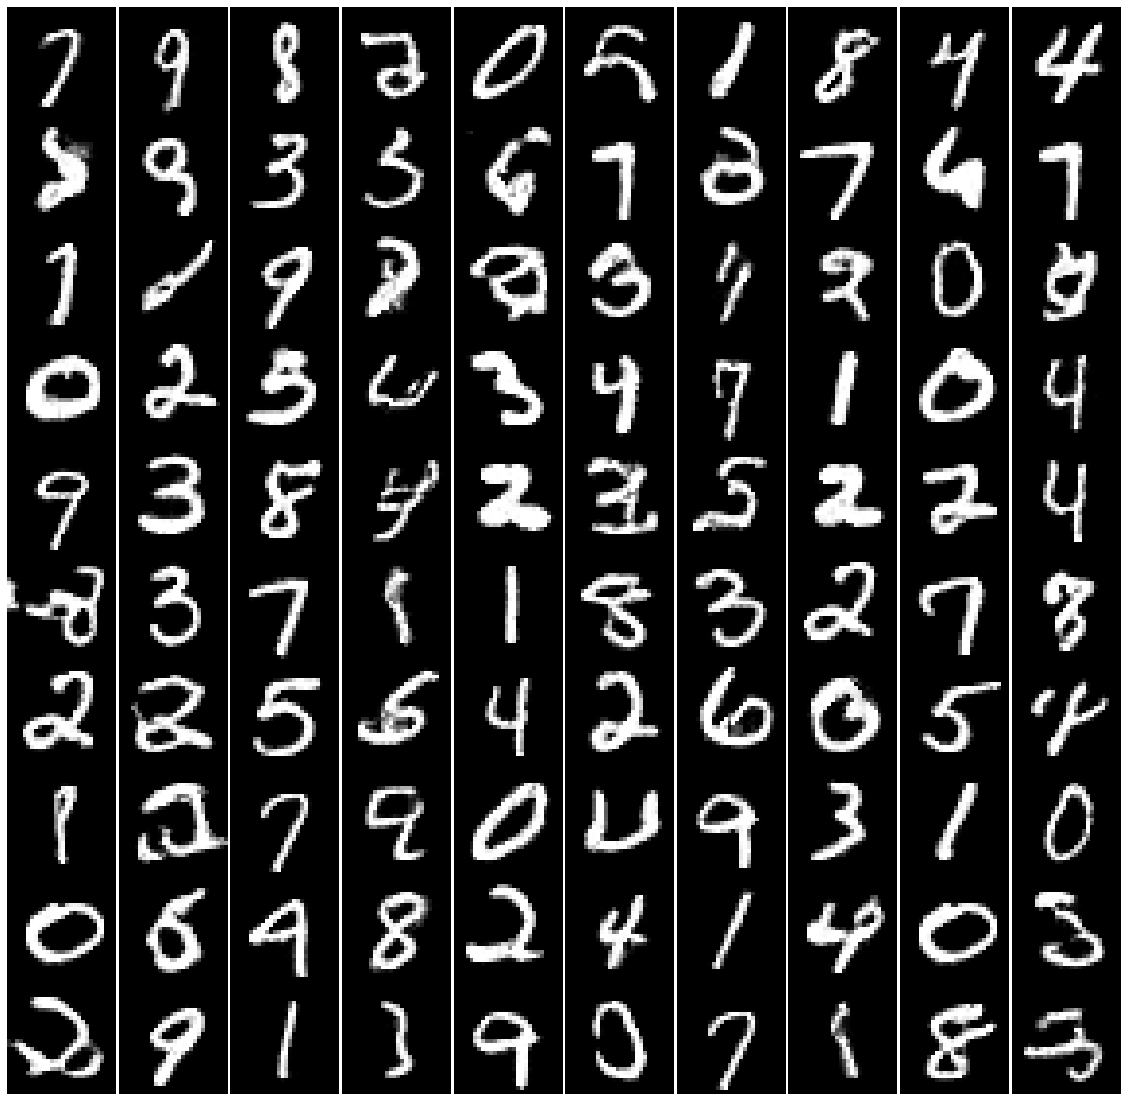

In [ ]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        idx = np.random.randint(len(B))
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(B[idx].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig('ebm_mnist_v01.png', bbox_inches='tight', dpi=300)

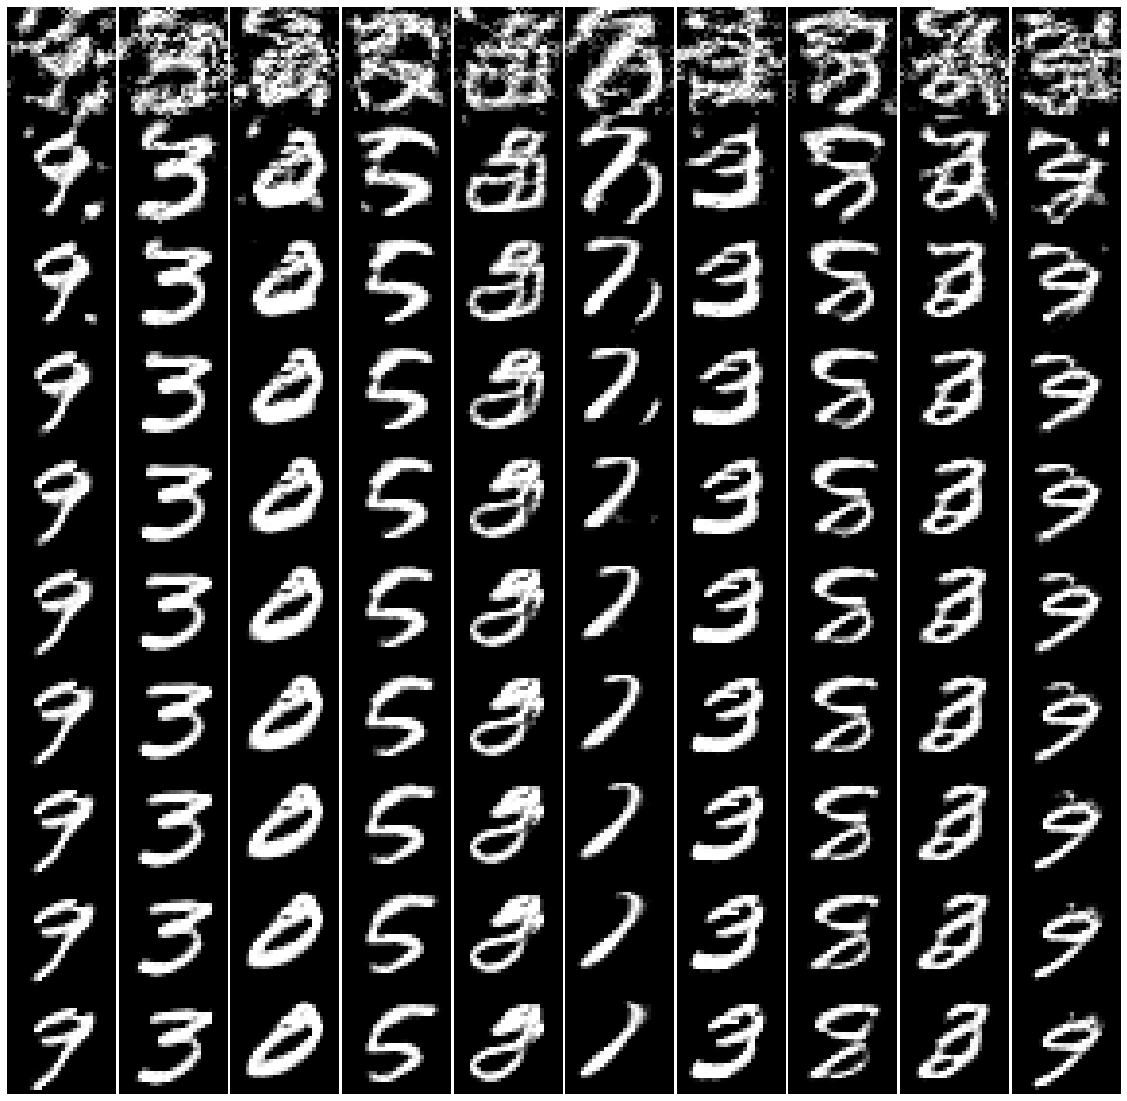

In [16]:
STEPS = 20
input_shape = [10, 1, 28, 28]
x_sample = [None] * 10
x_sample[0] = sample(loaded_net, [], input_shape, lambdaa, sigma, device, STEPS)
for i in range(1, 10):
    x_sample[i] = sample(loaded_net, [], input_shape, lambdaa, sigma, device, STEPS, x0=x_sample[i - 1])

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(x_sample[i][j].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig('ebm_mnist_v02.png', bbox_inches='tight', dpi=300)

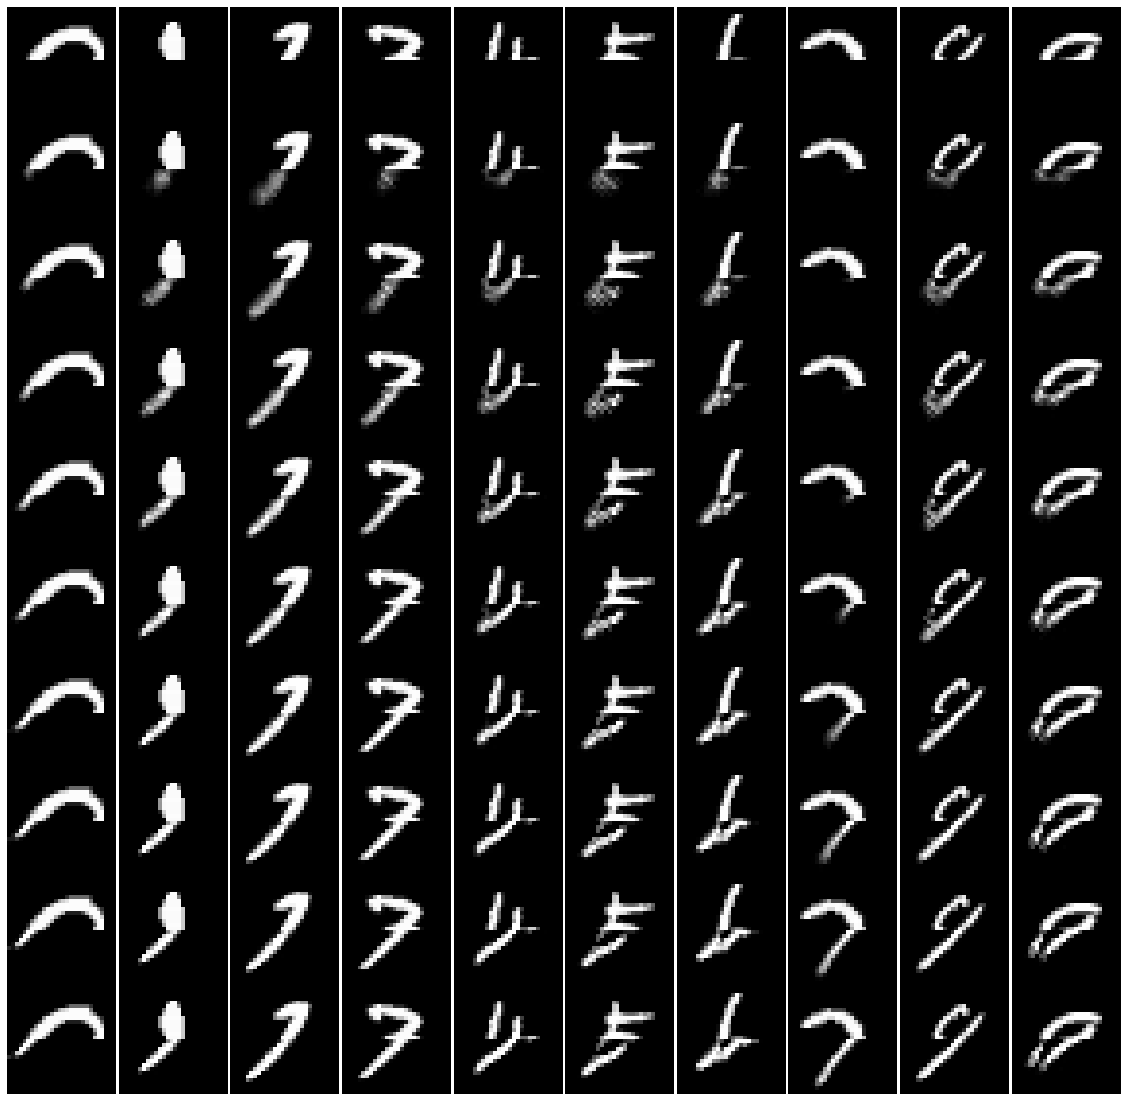

In [41]:
STEPS = 20
input_shape = [10, 1, 28, 28]
x_sample = [None] * 10

x_list = []
for i in range(10):
    y = -1
    while y != i:
        idx = np.random.randint(len(mnist_train))
        y = mnist_train[idx][1]
    x = mnist_train[idx][0]
    x_list.append(x)

X = torch.stack(x_list, dim=0).to(device)
mask = torch.ones_like(X)
mask[:, :, :14, :] = 0
X *= (1 - mask)

x_sample[0] = X
for i in range(1, 10):
    x_sample[i] = sample(loaded_net, [], input_shape, lambdaa, sigma, device, STEPS, x0=x_sample[i - 1], mask=mask)

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(x_sample[i][j].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig('ebm_mnist_000.png', bbox_inches='tight', dpi=300)

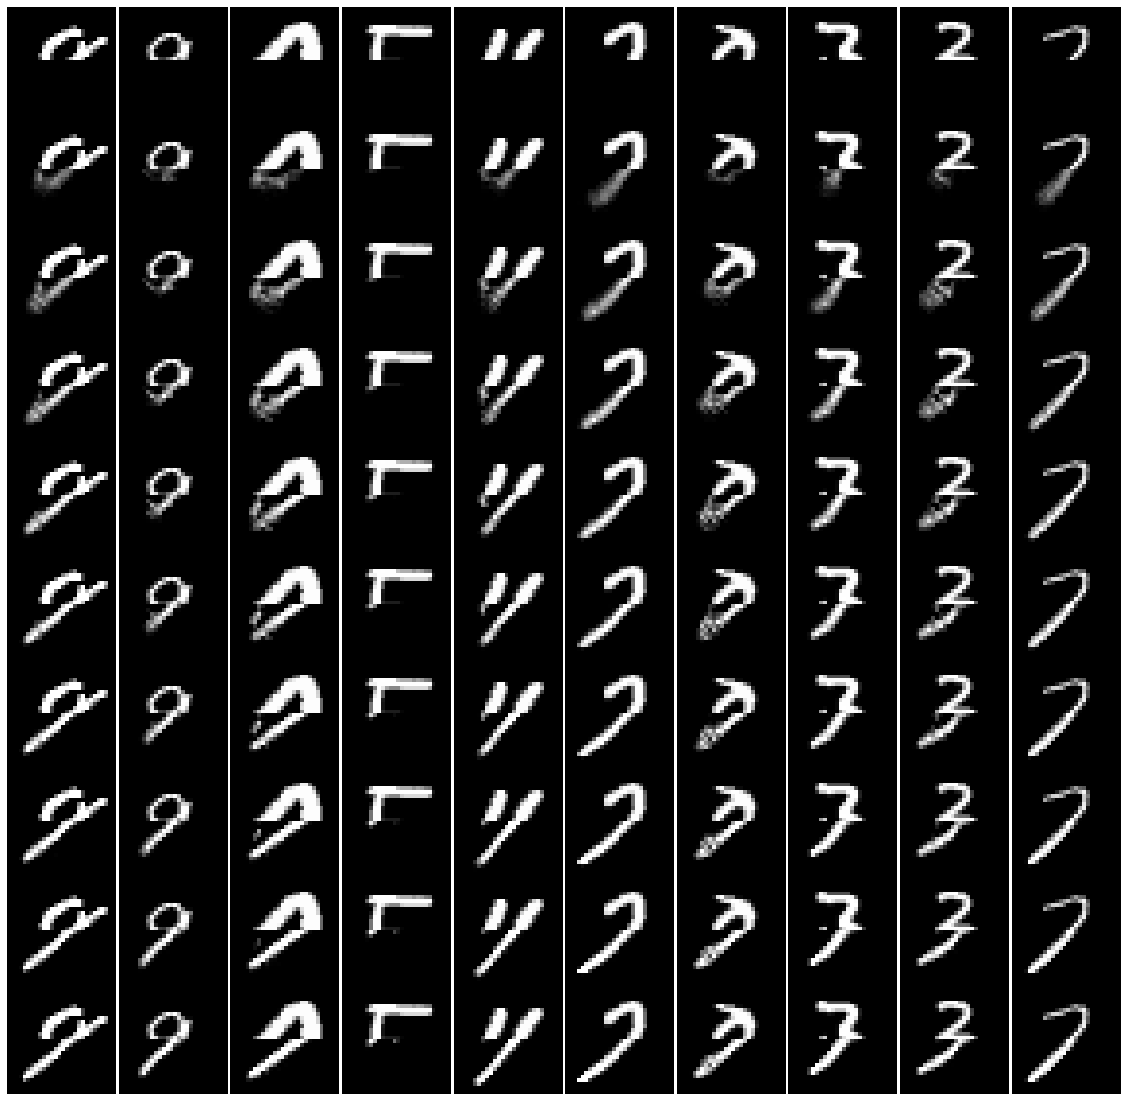

In [31]:
STEPS = 20
input_shape = [10, 1, 28, 28]
x_sample = [None] * 10

x_list = []
for i in range(10):
    idx = np.random.randint(len(mnist_train))
    x = mnist_train[idx][0]
    x_list.append(x)

X = torch.stack(x_list, dim=0).to(device)
mask = torch.ones_like(X)
mask[:, :, :14, :] = 0
X *= (1 - mask)

x_sample[0] = X
for i in range(1, 10):
    x_sample[i] = sample(loaded_net, [], input_shape, lambdaa, sigma, device, STEPS, x0=x_sample[i - 1], mask=mask)

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(x_sample[i][j].view(28, 28).detach().cpu(), cmap='gray', vmin=0, vmax=1)

fig.savefig('ebm_mnist_v03.png', bbox_inches='tight', dpi=300)